### Initial setup

In [1]:
#Import libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import theano
import theano.tensor as tt
import arviz as az
import pymc3 as pm

import warnings
warnings.simplefilter(action="ignore")

print("Packages uploaded successfully!")

Packages uploaded successfully!


### Data preparation

In [2]:
#Read data
data = pd.read_csv('./machine_readable_dnt.csv')

In [3]:
#Standardise continuous values
data_prep = data[['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                  'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['SLogP', 'Cbrain/Cblood','Syn_EC30', 
                       'Viability_EC30', 'NNF EC50min', 'NNF EC50max', 'Viability_LDH']

#Add other discrete values and details
discrete = data [['ID', 'Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF, Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

In [4]:
# ### Define predictors and outcomes

#BDNF given by continuous and discrete variables
x_bdnf = pd.DataFrame(data[['SLogP', 'Cbrain/Cblood', 'BBB', 
                            'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF, Reduction']]).values

#Syn
x_syn = pd.DataFrame(data[['Syn_EC30', 'Viability_EC30']]).values
Y_syn = pd.DataFrame(data[['Activity_Syn']]).values

#NNF
x_nnf = pd.DataFrame(data[['NNF EC50min', 'NNF EC50max', 'Viability_LDH']]).values
Y_nnf = pd.DataFrame(data[['Activity_NNF']]).values

#x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
Y_dnt = pd.DataFrame(data[['DNT']]).values

### Strategy: Imputation by distribution

In [5]:
# ### Mask missing values

#BDNF
x_bdnf_missing = np.isnan(x_bdnf)
print(f"BDNF predictor shape={x_bdnf.shape}, contains {x_bdnf_missing.sum()} missing value")
X_bdnf_train = np.ma.masked_array(x_bdnf, mask=x_bdnf_missing)
y_bdnf_missing = np.isnan(y_bdnf)
print(f"BDNF shape={y_bdnf.shape}, contains {y_bdnf_missing.sum()} missing value")
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

#Syn
x_syn_missing = np.isnan(x_syn)
print(f"Syn predictor shape={x_syn.shape}, contains {x_syn_missing.sum()} missing value")
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)
y_syn_missing = np.isnan(Y_syn)
print(f"Syn shape={Y_syn.shape}, contains {y_syn_missing.sum()} missing value")
Y_syn_train = np.ma.masked_array(Y_syn, mask=y_syn_missing)

#NNF
x_nnf_missing = np.isnan(x_nnf)
print(f"NNF predictor shape={x_nnf.shape}, contains {x_nnf_missing.sum()} missing value")
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)
y_nnf_missing = np.isnan(Y_nnf)
print(f"NNF shape={Y_nnf.shape}, contains {y_nnf_missing.sum()} missing value")
Y_nnf_train = np.ma.masked_array(Y_nnf, mask=y_nnf_missing)

#DNT
y_dnt_missing = np.isnan(Y_dnt)
print(f"DNT shape={Y_dnt.shape}, contains {y_dnt_missing.sum()} missing value")
Y_dnt_train = np.ma.masked_array(Y_dnt, mask=y_dnt_missing)

BDNF predictor shape=(97, 6), contains 115 missing value
BDNF shape=(97, 1), contains 60 missing value
Syn predictor shape=(97, 2), contains 60 missing value
Syn shape=(97, 1), contains 0 missing value
NNF predictor shape=(97, 3), contains 40 missing value
NNF shape=(97, 1), contains 0 missing value
DNT shape=(97, 1), contains 0 missing value


### Define and fit the model

In [6]:
with pm.Model() as model_cov:
    #Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    #Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))

In [7]:
# ## Define BDNF 
with model_cov:
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sigma=1, 
                         shape=(X_bdnf_train.shape[-1] - 2, 1))
    _bdnf_raw = pm.Normal('_bdnf_raw', mu=0, sigma=1,
                          shape=(X_bdnf_train.shape[-1], X_bdnf_train.shape[0]))
    bdnf_chol, *_ = pm.LKJCholeskyCov(
        "bdnf_chol", 
        n=X_bdnf_train.shape[-1], eta=1.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    Xmu_bdnf_ = tt.concatenate([tt.zeros([2, 1]), Xmu_bdnf], axis=0)
    bdnf_rotated = (Xmu_bdnf_ + tt.dot(bdnf_chol, _bdnf_raw)).T
    bdnf_predictor_continue = pm.Normal(
        'bdnf_predictor_continue',
        mu=bdnf_rotated[:, :2], sigma=.05,
        observed=X_bdnf_train[:, :2])
    bdnf_predictor_binary = pm.Bernoulli(
        'bdnf_predictor_binary',
        logit_p=bdnf_rotated[:, 2:],
        observed=X_bdnf_train[:, 2:])
    
    X_bdnf_modelled = tt.concatenate(
        [bdnf_predictor_continue, bdnf_predictor_binary],
        axis=-1
    )

    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', tt.dot(X_bdnf_modelled, beta_bdnf))
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)

In [8]:
# ## Define SYN
with model_cov:
    # Imputation of X missing values for Syn
    syn_chol, *_ = pm.LKJCholeskyCov(
        "syn_chol", 
        n=X_syn_train.shape[-1], eta=1.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    X_syn_modelled = pm.MvNormal(
        'X_syn_modelled',
        mu=0., chol=syn_chol,
        observed=X_syn_train)
   
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + tt.dot(X_syn_modelled, beta_syn))    
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p=lp_syn, observed=Y_syn_train)

In [9]:
# ## Define NNF
with model_cov:
    # Imputation of X missing values for NNF
    nnf_chol, *_ = pm.LKJCholeskyCov(
        "nnf_chol", 
        n=X_nnf_train.shape[-1], eta=.5, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False
    )
    X_nnf_modelled = pm.MvNormal(
        'X_nnf_modelled',
        mu=0., chol=nnf_chol,
        observed=X_nnf_train)
   
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + tt.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf_train)

In [10]:
# ## Define DNT
with model_cov:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt_train)

In [11]:
# ## Checking the proposed structure of model
model_cov.check_test_point()

mu_beta                                3.69
sd_beta_log__                         -0.77
beta_bdnf                            -13.82
beta_syn                              -4.61
beta_nnf                              -6.91
Xmu_bdnf                              -3.68
_bdnf_raw                           -534.82
bdnf_chol_cholesky-cov-packed__       -0.92
bdnf_predictor_continue_missing        0.00
bdnf_predictor_binary_missing          0.00
y_obs_bdnf_missing                     0.00
syn_chol_cholesky-cov-packed__        -0.76
X_syn_modelled_missing                 0.00
nnf_chol_cholesky-cov-packed__         0.35
X_nnf_modelled_missing                 0.00
bdnf_predictor_continue           -35997.10
bdnf_predictor_binary               -268.94
y_obs_bdnf                           -67.24
X_syn_modelled                      -245.27
y_obs_syn                            -67.24
X_nnf_modelled                      -392.91
y_obs_nnf                            -67.24
y_obs_dnt                       

In [12]:
# ## Make the inferences
with model_cov:
    trace_cov = pm.sample(cores=4, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, nnf_chol, X_syn_modelled_missing, syn_chol, bdnf_predictor_continue_missing, bdnf_chol, _bdnf_raw, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [bdnf_predictor_binary_missing, y_obs_bdnf_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 357 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
# ## Compute prior and posterior distributions
#with model_cov:
    #prior_all_cov = pm.sample_prior_predictive(1000) #ERROR shape mismatch
    #posterior_all_cov = pm.sample_posterior_predictive(trace_cov) #ERROR tuple index out of range

### Check convergence

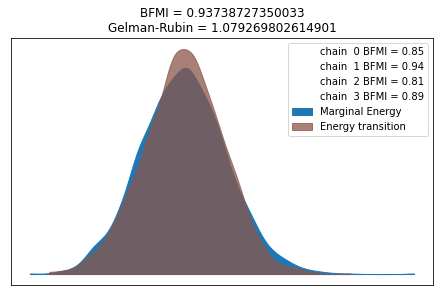

In [17]:
# Check the energy plot
bfmi = np.max(pm.stats.bfmi(trace_cov))
max_gr = max(np.max(gr_stats) for gr_stats in pm.stats.rhat(trace_cov).values()).values
(pm.energyplot(trace_cov, legend=True, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

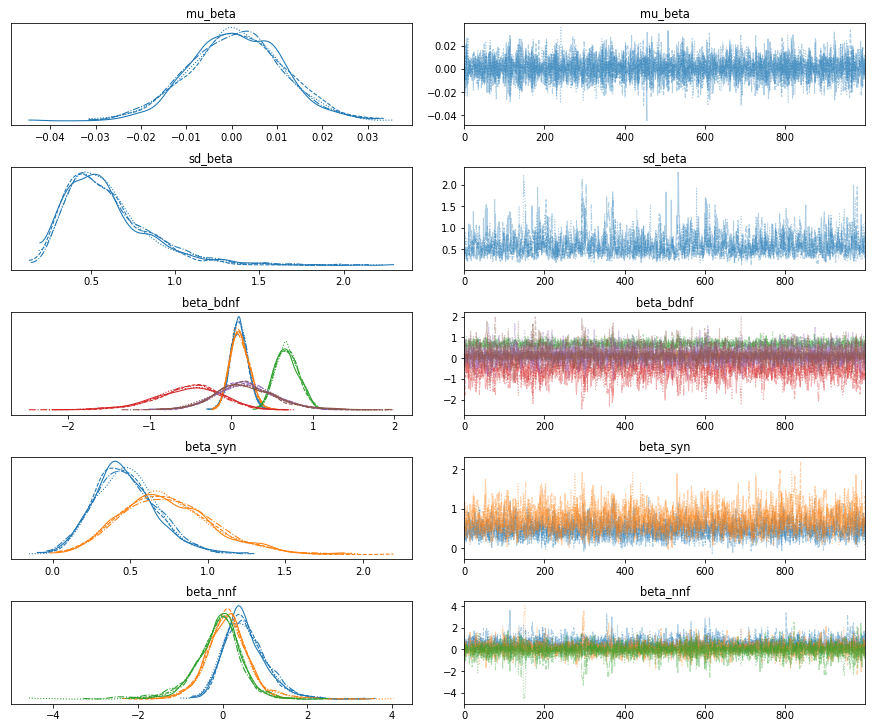

In [18]:
# Check hyperparameters and parameters
pm.traceplot(trace_cov, var_names=['mu_beta', 'sd_beta', 'beta_bdnf', 'beta_syn', 'beta_nnf']);

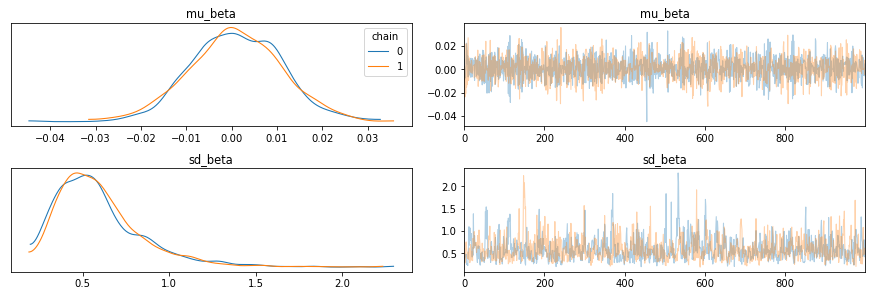

In [19]:
# Check convergence for hyperpriors of two chains
az.plot_trace(trace_cov, var_names=['mu_beta', 'sd_beta'],
             coords={"chain":[0,1]}, legend=True)
#plt.suptitle("Trace plots")
plt.show()

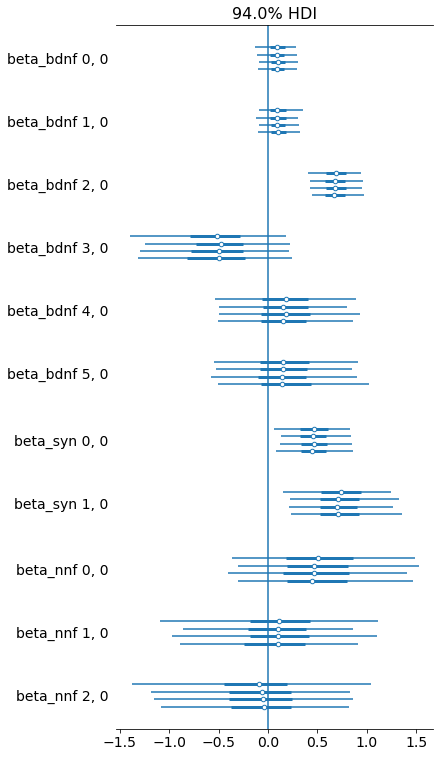

In [20]:
# Plot parameters
ax = pm.forestplot(trace_cov, var_names=['beta_bdnf', 'beta_syn', 'beta_nnf']);
ax[0].vlines(0., *ax[0].get_ylim());

In [21]:
# Statistical summary
az.summary(trace_cov)

#Save the statistical summary of the trace
#file = az.summary(trace, round_to=None)
#file.to_csv('Statistical_summary_trace.csv')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_beta,0.001,0.010,-0.018,0.021,0.000,0.000,7988.0,1564.0,8006.0,2811.0,1.0
"beta_bdnf[0,0]",0.097,0.106,-0.102,0.302,0.002,0.001,4299.0,3272.0,4323.0,3531.0,1.0
"beta_bdnf[1,0]",0.106,0.116,-0.091,0.336,0.002,0.002,3167.0,2867.0,3205.0,3400.0,1.0
"beta_bdnf[2,0]",0.688,0.145,0.415,0.948,0.004,0.002,1700.0,1700.0,1704.0,2764.0,1.0
"beta_bdnf[3,0]",-0.534,0.416,-1.318,0.232,0.012,0.008,1286.0,1236.0,1340.0,1776.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"lp_dnt[92,0]",-0.067,1.515,-2.842,2.775,0.020,0.021,5911.0,2619.0,5915.0,3743.0,1.0
"lp_dnt[93,0]",-1.235,1.710,-4.526,1.852,0.028,0.024,3825.0,2535.0,4310.0,2978.0,1.0
"lp_dnt[94,0]",0.017,1.495,-2.770,2.815,0.019,0.021,5918.0,2655.0,5871.0,3630.0,1.0
"lp_dnt[95,0]",-0.176,1.566,-3.234,2.565,0.021,0.021,5513.0,2762.0,5698.0,3631.0,1.0


In [22]:
# Helper functions
def convergence_hist(hist_data):
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.hist(hist_data, bins=50, color="#1f77b4", ec="#3d5167", alpha=0.9, lw=1.2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.yticks(ticks=None)

    return fig, ax

#R-hat
def check_rhat(inf_data, threshold=1.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["r_hat"])
    #ax.set_xlabel("Rhat statistic", labelpad=15)
    ax.set_title("$\hat{R}$")

    bad = s[s["r_hat"] > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(f"The following parameters have an Rhat greater {threshold}:\n{text}\n")
    return fig, ax

#MCSE
def check_mcse(inf_data, threshold=0.1, verbose=True):
    s = az.summary(inf_data, round_to="none")
    hist_data = s["mcse_mean"] / s["sd"]
    fig, ax = convergence_hist(hist_data)
    #ax.set_xlabel("Monte Carlo standard error / posterior sd", labelpad=15)
    ax.set_title("Monte Carlo Standard Error/Posterior sd")
    ax.locator_params(axis='x', nbins=5)

    bad = s[hist_data > threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have a Monte Carlo standard error greater than {threshold * 100}% of the posterior standard deviation:\n{text}\n")
    return fig, ax

#ESS/NEFF, number of effective sample size
def check_neff(inf_data, threshold=0.1, verbose=True):
    N = inf_data.posterior.dims['chain'] * inf_data.posterior.dims['draw']
    s = az.summary(inf_data, round_to="none")
    fig, ax = convergence_hist(s["ess_mean"] / N)
    #ax.set_xlabel("Effective sample size / iterations", labelpad=15)
    ax.set_title("$n_{eff}/N$")

    bad = s[s["ess_mean"] / N < threshold]
    if len(bad) == 0:
        text = "None"
    else:
        text = list(bad.index)
        ax.axvline(x=threshold, c="#3d5167", lw=2)
    if verbose:
        print(
            f"The following parameters have an effective sample size less than {threshold * 100}% of the total sample size:\n{text}\n")
    return fig, ax

The following parameters have an Rhat greater 1.05:
['_bdnf_raw[1,0]', '_bdnf_raw[1,5]', '_bdnf_raw[1,7]', '_bdnf_raw[1,8]', '_bdnf_raw[1,10]', '_bdnf_raw[1,13]', '_bdnf_raw[1,16]', '_bdnf_raw[1,19]', '_bdnf_raw[1,23]', '_bdnf_raw[1,29]', '_bdnf_raw[1,30]', '_bdnf_raw[1,36]', '_bdnf_raw[1,37]', '_bdnf_raw[1,38]', '_bdnf_raw[1,40]', '_bdnf_raw[1,49]', '_bdnf_raw[1,51]', '_bdnf_raw[1,54]', '_bdnf_raw[1,55]', '_bdnf_raw[1,57]', '_bdnf_raw[1,66]', '_bdnf_raw[1,67]', '_bdnf_raw[1,75]', '_bdnf_raw[1,76]', '_bdnf_raw[1,77]', '_bdnf_raw[1,87]', '_bdnf_raw[1,90]', '_bdnf_raw[1,93]', '_bdnf_raw[1,95]', 'bdnf_chol[1]']

The following parameters have a Monte Carlo standard error greater than 10.0% of the posterior standard deviation:
['_bdnf_raw[0,24]', '_bdnf_raw[0,28]', '_bdnf_raw[0,33]', '_bdnf_raw[0,37]', '_bdnf_raw[0,60]', '_bdnf_raw[0,63]', '_bdnf_raw[0,77]', '_bdnf_raw[1,0]', '_bdnf_raw[1,1]', '_bdnf_raw[1,5]', '_bdnf_raw[1,7]', '_bdnf_raw[1,8]', '_bdnf_raw[1,10]', '_bdnf_raw[1,13]', '_bdnf

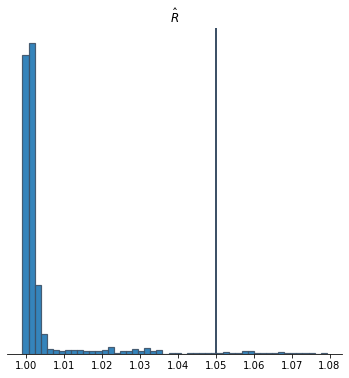

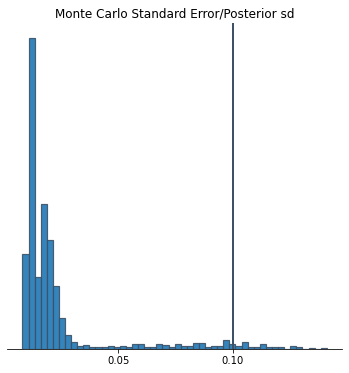

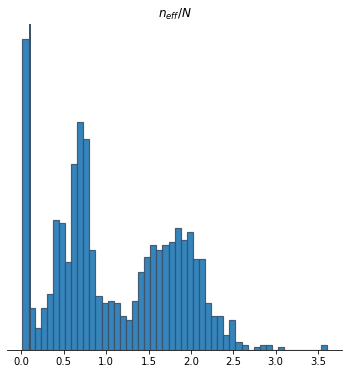

In [23]:
# Plot statistical summary of convergences
check_rhat(trace_cov, threshold=1.05); #1.005 also considered
check_mcse(trace_cov);
check_neff(trace_cov);

### Check goodness of fit

In [ ]:
###ERROR
# Convert to Arviz
idata = az.from_pymc3(trace_hierar, 
                      posterior_predictive=posterior_all_hierar, 
                      model = model_hierar)

In [ ]:
#ERROR
# Plot observed vs posterior predictive vs posterior mean
az.plot_ppc(idata); #kind='density'

In [ ]:
#ERROR
# Plot posterior of compounds
pm.plot_posterior(posterior_all_hierar, var_names=['lp_bdnf', 'lp_syn', 'lp_nnf', 'lp_dnt']);

In [ ]:
###Can I switch with posterior_all_hierar and get similar to trace?
# Plot traces each compound
pm.forestplot(trace_hierar, var_names='lp_bdnf'); 
pm.forestplot(trace_hierar, var_names='lp_syn');
pm.forestplot(trace_hierar, var_names='lp_nnf');
pm.forestplot(trace_hierar, var_names='lp_dnt');

In [ ]:
###ERROR
# Compare prior with posterior
sns.distplot(prior['beta_bdnf'], label='Prior', hist=False)
ax = sns.distplot(trace.posterior['beta_bdnf'], label='Posterior', hist=False)
ax.legend();

### Strategy: Imputation by mean

In [13]:
# ### Strategy two: imputation given by the mean
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

#BDNF
X_bdnf = imp_mean.fit_transform(x_bdnf)
Y_bdnf = imp_mean.fit_transform(y_bdnf)

#Syn
X_syn = imp_mean.fit_transform(x_syn)

#NNF
X_nnf = imp_mean.fit_transform(x_nnf)

In [14]:
with pm.Model() as cov_meanimpute:
    #Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=5)
    #Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(3,1))

In [15]:
with cov_meanimpute:
    #LKJ prior for covariance matrix    
    bdnf_chol, corr, stds = pm.LKJCholeskyCov(
        'bdnf_chol', n=6, eta=1.0, sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=True, store_in_trace=False)
    
    mu_bdnf = pm.Normal('mu_bdnf', mu=0, sd=1, shape=6)
    y_bdnf = pm.MvNormal('y_bdnf', mu=mu_bdnf, chol=bdnf_chol, observed=X_bdnf)
    
    # Likelihood for BDNF
    #SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf =  pm.Deterministic('lp_bdnf', tt.dot(y_bdnf, beta_bdnf))    
    y_obs_bdnf = pm.Bernoulli("y_obs_bdnf", logit_p=lp_bdnf, observed=Y_bdnf)

In [16]:
with cov_meanimpute:
    #LKJ prior for covariance matrix    
    syn_chol, corr, stds = pm.LKJCholeskyCov(
        'syn_chol', n=2, eta=1.0, sd_dist=pm.HalfNormal.dist(1.0), 
        compute_corr=True, store_in_trace=False)
    
    mu_syn = pm.Normal('mu_syn', mu=0, sd=1, shape=2)
    y_syn = pm.MvNormal('y_syn', mu=mu_syn, chol=syn_chol, observed=X_syn)
    
    # Likelihood for Syn
    #BDNF->SYN
    lp_syn =  pm.Deterministic('lp_syn', lp_bdnf + tt.dot(y_syn, beta_syn))    
    y_obs_syn = pm.Bernoulli('y_obs_syn', logit_p=lp_syn, observed=Y_syn)

In [17]:
with cov_meanimpute:
    #LKJ prior for covariance matrix    
    nnf_chol, corr, stds = pm.LKJCholeskyCov(
        'nnf_chol', n=3, eta=1.0, sd_dist=pm.HalfNormal.dist(1.0), 
        compute_corr=True, store_in_trace=False)
    
    mu_nnf = pm.Normal('mu_nnf', mu=0, sd=1, shape=3)
    y_nnf = pm.MvNormal('y_nnf', mu=mu_nnf, chol=nnf_chol, observed=X_nnf)
    
    # Likelihood for NNF
    #BDNF->SYN->NNF
    lp_nnf =  pm.Deterministic('lp_nnf', lp_syn + tt.dot(y_nnf, beta_nnf))    
    y_obs_syn = pm.Bernoulli('y_obs_nnf', logit_p=lp_nnf, observed=Y_nnf)

In [18]:
with cov_meanimpute:
    #Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt)

In [19]:
#Checking the proposed structure of model
cov_meanimpute.check_test_point()

mu_beta                              3.69
sd_beta_log__                       -0.77
beta_bdnf                          -13.82
beta_syn                            -4.61
beta_nnf                            -6.91
bdnf_chol_cholesky-cov-packed__     -0.92
mu_bdnf                             -5.51
syn_chol_cholesky-cov-packed__      -0.76
mu_syn                              -1.84
nnf_chol_cholesky-cov-packed__      -0.58
mu_nnf                              -2.76
y_bdnf                            -680.69
y_obs_bdnf                         -67.24
y_syn                             -245.27
y_obs_syn                          -67.24
y_nnf                             -392.91
y_obs_nnf                          -67.24
y_obs_dnt                          -67.24
Name: Log-probability of test_point, dtype: float64

In [21]:
with cov_meanimpute:
    trace_cov_meanimpute = pm.sample(cores=4, return_inferencedata=True, target_accept=0.90)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_nnf, nnf_chol, mu_syn, syn_chol, mu_bdnf, bdnf_chol, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 239 seconds.


### Model comparison

In [ ]:
#ERROR
model_cov.name = 'model_cov'
cov_meanimpute.name = 'cov_meanimpute'

df_comp_WAIC = pm.compare({model_cov: trace_cov, cov_meanimpute: trace_cov_meanimpute})
df_comp_WAIC

df_comp_LOO = pm.compare({model_cov: trace_cov, cov_meanimpute: trace_cov_meanimpute}, ic='LOO')
df_comp_LOO

In [ ]:
#ERROR
data1 = az.load_arviz_data("model_cov")
data2 = az.load_arviz_data("cov_meanimpute")
compare_dict = {"model_cov": data1, "cov_meanimpute": data2}
az.compare(compare_dict)

In [26]:
data_model_meanimpute = az.convert_to_inference_data (trace_cov_meanimpute)
data_model_hierar = az.convert_to_inference_data (trace_cov)

#### Watanabe - Akaike Information Criterion [WAIC]

In [27]:
model_meanimpute_waic = pm.waic(data_model_meanimpute, cov_meanimpute, var_name='y_obs_bdnf')
model_meanimpute_waic.waic

-74.55613602236409

In [28]:
model_hierar_waic = pm.waic(data_model_hierar, model_cov, var_name='y_obs_bdnf')
model_hierar_waic.waic

nan

In [29]:
model_meanimpute_waic = pm.waic(data_model_meanimpute, cov_meanimpute, var_name='y_obs_syn')
model_meanimpute_waic.waic

-62.13967507822807

In [30]:
model_hierar_waic = pm.waic(data_model_hierar, model_cov, var_name='y_obs_syn')
model_hierar_waic.waic

-66.06302907874617

In [31]:
model_meanimpute_waic = pm.waic(data_model_meanimpute, cov_meanimpute, var_name='y_obs_nnf')
model_meanimpute_waic.waic

-62.41646858257918

In [32]:
model_hierar_waic = pm.waic(data_model_hierar, model_cov, var_name='y_obs_nnf')
model_hierar_waic.waic

-63.74921152897766

In [33]:
model_meanimpute_waic = pm.waic(data_model_meanimpute, cov_meanimpute, var_name='y_obs_dnt')
model_meanimpute_waic.waic

-53.31651172495573

In [34]:
model_hierar_waic = pm.waic(data_model_hierar, model_cov, var_name='y_obs_dnt')
model_hierar_waic.waic

-45.10974436447833

#### Leave-one-out Cross-Validation [LOO]

In [37]:
model_meanimpute_loo = pm.loo(data_model_meanimpute, cov_meanimpute, var_name='y_obs_bdnf')
model_meanimpute_loo.loo

-74.55705951752856

In [38]:
model_hierar_loo = pm.loo(data_model_hierar, model_cov, var_name='y_obs_bdnf')
model_hierar_loo.loo

nan

In [39]:
model_meanimpute_loo = pm.loo(data_model_meanimpute, cov_meanimpute, var_name='y_obs_syn')
model_meanimpute_loo.loo

-62.14012000849129

In [40]:
model_hierar_loo = pm.loo(data_model_hierar, model_cov, var_name='y_obs_syn')
model_hierar_loo.loo

-66.32102999793355

In [41]:
model_meanimpute_loo = pm.loo(data_model_meanimpute, cov_meanimpute, var_name='y_obs_nnf')
model_meanimpute_loo.loo

-62.44301290131739

In [42]:
model_hierar_loo = pm.loo(data_model_hierar, model_cov, var_name='y_obs_nnf')
model_hierar_loo.loo

-63.95503906342182

In [43]:
model_meanimpute_loo = pm.loo(data_model_meanimpute, cov_meanimpute, var_name='y_obs_dnt')
model_meanimpute_loo.loo

-53.35826725122695

In [44]:
model_hierar_loo = pm.loo(data_model_hierar, model_cov, var_name='y_obs_dnt')
model_hierar_loo.loo

-46.30144662707052

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w